In [1]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse

from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

import pymorphy2
morph = pymorphy2.MorphAnalyzer()

import pickle

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [01:26, 2332.79it/s]


#  Домашнее задание по NLP # 1 [100 баллов]
## Классификация по тональности 

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5. 

Тексты хранятся в json-ах в массиве responses.

Посмотрим на пример отзыва:

In [4]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

## Часть 1. Анализ текстов [40/100]

1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах
3. Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм 
* существительных
4. Постройте кривые Ципфа и Хипса
5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?
6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

## 1

In [5]:
cities = {}
for response in responses:
    if response['city'] in cities:
        cities[response['city']] += 1
    else:
        cities[response['city']] = 0

In [6]:
banks = {}
for response in responses:
    if response['bank_name'] in banks:
        banks[response['bank_name']] += 1
    else:
        banks[response['bank_name']] = 0

## 2

In [7]:
lens = {}
for response in responses:
    if len(response['text']) in lens:
        lens[len(response['text'])] += 1
    else:
        lens[len(response['text'])] = 0

(0, 5000)

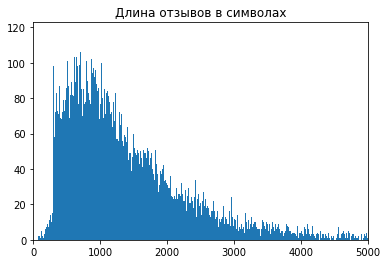

In [8]:
plt.bar(lens.keys(), lens.values(), width=1)
plt.title('Длина отзывов в символах')
plt.xlim(0,5000)

In [9]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     D:\Users\melts\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
for response in tqdm(responses):
    response['text'] = word_tokenize(response['text'])
    response['text'] = [word for word in response['text'] if word.isalnum()]

100%|█████████████████████████████████████████████████████████████████████████| 153499/153499 [06:12<00:00, 411.79it/s]


In [11]:
lens = {}
for response in tqdm(responses):
    if len(response['text']) in lens:
        lens[len(response['text'])] += 1
    else:
        lens[len(response['text'])] = 0

100%|█████████████████████████████████████████████████████████████████████| 153499/153499 [00:00<00:00, 1211876.43it/s]


(0, 1000)

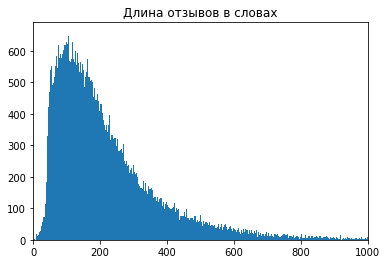

In [12]:
plt.bar(lens.keys(), lens.values(), width=1)
plt.title('Длина отзывов в словах')
plt.xlim(0,1000)

## 3

In [13]:
words = {}
for response in tqdm(responses):
    for word in response['text']:
        word = word.lower()
        if word in words:
            words[word] += 1
        else:
            words[word] = 0

words = {k: v for k, v in sorted(words.items(), key=lambda item: item[1], reverse=True)}
print('10ка самых популярных слов: ', list(words.keys())[:10])

100%|████████████████████████████████████████████████████████████████████████| 153499/153499 [00:19<00:00, 7825.82it/s]


10ка самых популярных слов:  ['в', 'и', 'не', 'на', 'что', 'я', 'с', 'по', 'мне', 'банка']


In [14]:
stop_words = set(stopwords.words('russian')) 

words_nostop = {}
for word, count in words.items():
    if word not in stop_words:
        words_nostop[word] = count
        
print('10ка самых популярных слов без стоп-слов: ', list(words_nostop.keys())[:10])

10ка самых популярных слов без стоп-слов:  ['банка', 'банк', 'это', 'деньги', 'карту', 'карты', 'кредит', 'день', 'заявление', 'отделение']


In [15]:
# очистка стоп слов для дальнейщей работы
for response in tqdm(responses):
    response['text'] = [word for word in response['text'] if word not in stop_words]

100%|███████████████████████████████████████████████████████████████████████| 153499/153499 [00:04<00:00, 38185.27it/s]


In [16]:
words_lemma = {}
words_noun = {}

for word, count in tqdm(words_nostop.items()):
    lemma = morph.parse(word)[0]
    if lemma.normal_form in words_lemma:
        words_lemma[lemma.normal_form] += count
    else:
        words_lemma[lemma.normal_form] = count
        
    if 'NOUN' in lemma.tag:
        if lemma.normal_form in words_noun:
            words_noun[lemma.normal_form] += count
        else:
            words_noun[lemma.normal_form] = count

words_lemma = {k: v for k, v in sorted(words_lemma.items(), key=lambda item: item[1], reverse=True)}
words_noun = {k: v for k, v in sorted(words_noun.items(), key=lambda item: item[1], reverse=True)}

100%|████████████████████████████████████████████████████████████████████████| 313422/313422 [00:54<00:00, 5778.52it/s]


In [17]:
print('10ка самых популярных лемм: ', list(words_lemma.keys())[:10])

10ка самых популярных лемм:  ['банка', 'карта', 'банк', 'это', 'деньга', 'день', 'мой', 'кредит', 'который', 'отделение']


**Банка - это конечно не емкость для жидкостей.**

## 4

In [18]:
print('10ка самых популярных существительных: ', list(words_noun.keys())[:10])

10ка самых популярных существительных:  ['банка', 'карта', 'банк', 'деньга', 'день', 'кредит', 'отделение', 'счёт', 'сотрудник', 'клиент']


## 5

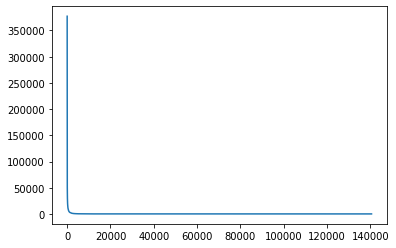

In [19]:
import numpy as np

cipfa = [x for x in words_lemma.values()]
plt.plot(cipfa)  

Похоже на закон Ципфа

**Кривая Хипса - это что-то другое? Или тоже самое, инет молчит.**
## 6

In [20]:
print('Слово "сотрудник" встречается чаще чем "клиент": ', words_lemma['сотрудник'] > words_lemma['клиент'])
print('Слово "мошенничество" встречается {} раз'.format(words_lemma['мошенничество']))
print('Слово "доверие" встречается {} раз'.format(words_lemma['доверие']))

Слово "сотрудник" встречается чаще чем "клиент":  True
Слово "мошенничество" встречается 3220 раз
Слово "доверие" встречается 2091 раз


## 7

In [21]:
from multiprocessing import Process, Manager, cpu_count, Queue
import lemmatize

In [22]:
%time
manager = Manager()
resp = manager.list()
#resp = Queue()

# сколько элементов на один процесс
# responses = responses[:100]
cpu = cpu_count()
c = int(len(responses)/cpu)

threads = []
for i in range(cpu_count()):
    if i == cpu-1:
        threads.append(Process(target=lemmatize.lemmatize, args=(responses[c*i:], resp)))
    else:
        threads.append(Process(target=lemmatize.lemmatize, args=(responses[c*i:c+c*i], resp)))
    threads[-1].start()

[thread.join() for thread in threads]

Wall time: 0 ns


[None, None, None, None, None, None, None, None]

In [30]:
f = open('banks.pkl', 'wb')
pickle.dump(list(resp), f)
f.close()

In [4]:
f = open('banks.pkl', 'rb')
resp = pickle.load(f)
f.close()

In [5]:
import pandas as pd

def merge(words):
    return ' '. join(words)
    
resp_df = pd.DataFrame(resp)
resp_df['text'] = resp_df['text'].apply(merge)

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(analyzer='word', min_df = 100)
tfidf_matrix = tfidf.fit_transform(resp_df['text'])

## Часть 2. Тематическое моделирование [20/100]

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

Эта часть задания может быть сделана с использованием gensim. 

In [7]:
import scipy.sparse
from gensim import matutils, corpora
from gensim.models import LdaMulticore

# Трансформация матрицы слов в корпус
def get_corpus(word_matrix):
    # we have to transpose
    # convert from df to sparse matrix
    sparse_counts = scipy.sparse.csr_matrix(word_matrix.transpose())

    # sparse matrix to corpus
    return matutils.Sparse2Corpus(sparse_counts)


corpus = get_corpus(tfidf_matrix)

texts = [x['text'] for x in resp]
dictionary = corpora.Dictionary(texts)

In [8]:
topics = LdaMulticore(corpus, num_topics=100, id2word=dictionary, workers=8, passes=10, minimum_probability=0.02)

In [95]:
for i in range(topics.num_topics):
    print(topics.print_topic(i))

0.018*"однажды" + 0.000*"трекинг" + 0.000*"99" + 0.000*"спрашивать" + 0.000*"навязывание" + 0.000*"обратить" + 0.000*"роман" + 0.000*"неизменность" + 0.000*"наст" + 0.000*"вода"
0.023*"секрет" + 0.011*"сосед" + 0.011*"принять" + 0.005*"учёба" + 0.000*"paywave" + 0.000*"ошибка" + 0.000*"регион" + 0.000*"напрягать" + 0.000*"татьяна" + 0.000*"касательно"
0.029*"дошлый" + 0.000*"передать" + 0.000*"ажиотаж" + 0.000*"вывод" + 0.000*"бывший" + 0.000*"роман" + 0.000*"исключение" + 0.000*"штука" + 0.000*"спрашивать" + 0.000*"логичный"
0.022*"держатель" + 0.015*"зал" + 0.015*"конский" + 0.013*"присутствующий" + 0.009*"предыстория" + 0.009*"асв" + 0.007*"играть" + 0.007*"недолго" + 0.001*"нос" + 0.000*"отличать"
0.018*"сцена" + 0.014*"поделить" + 0.013*"малое" + 0.013*"маяковский" + 0.013*"честно" + 0.013*"уложиться" + 0.012*"менежер" + 0.012*"рублёвый" + 0.012*"однако" + 0.011*"высококвалифицированный"
0.017*"допускать" + 0.017*"заявление" + 0.015*"письменно" + 0.014*"цель" + 0.012*"фирма" + 0.0

0.028*"снова" + 0.019*"расписаться" + 0.015*"сроккредит" + 0.009*"подтверждение" + 0.007*"вправе" + 0.007*"лелеять" + 0.003*"ясность" + 0.002*"забеспокоиться" + 0.001*"0230" + 0.000*"быть"
0.020*"перейти" + 0.014*"надёжный" + 0.000*"на" + 0.000*"сознательно" + 0.000*"платный" + 0.000*"дело" + 0.000*"талон" + 0.000*"специальность" + 0.000*"передумать" + 0.000*"петергофский"
0.000*"вообщий" + 0.000*"отдельно" + 0.000*"сальск" + 0.000*"оскорблять" + 0.000*"обратить" + 0.000*"спрашивать" + 0.000*"роман" + 0.000*"имущество" + 0.000*"критерий" + 0.000*"относиться"
0.029*"отстоять" + 0.010*"короче" + 0.000*"намерение" + 0.000*"включиться" + 0.000*"администрация" + 0.000*"поток" + 0.000*"обратить" + 0.000*"1890" + 0.000*"40713718" + 0.000*"расстаться"
0.037*"предъявить" + 0.023*"признаться" + 0.011*"парочка" + 0.004*"учесть" + 0.002*"банковский" + 0.002*"яндекс" + 0.002*"жалоба" + 0.001*"стартовый" + 0.000*"машина" + 0.000*"скидка"
0.000*"недоработка" + 0.000*"намерение" + 0.000*"сальск" + 0.0

0.000*"социальный" + 0.000*"крестик" + 0.000*"роман" + 0.000*"обратить" + 0.000*"логичный" + 0.000*"эл" + 0.000*"напрягаться" + 0.000*"петергофский" + 0.000*"регистрация" + 0.000*"скандалить"
0.017*"подозрительный" + 0.006*"балет" + 0.005*"стоп" + 0.000*"спрашивать" + 0.000*"роман" + 0.000*"страхов" + 0.000*"расстаться" + 0.000*"регистрация" + 0.000*"обратить" + 0.000*"корп"
0.000*"худой" + 0.000*"кажется" + 0.000*"пропустить" + 0.000*"жутко" + 0.000*"обратить" + 0.000*"спрашивать" + 0.000*"роман" + 0.000*"организовывать" + 0.000*"отдельно" + 0.000*"эпилепсия"
0.001*"газета" + 0.000*"спрашивать" + 0.000*"сальск" + 0.000*"бывший" + 0.000*"1890" + 0.000*"неизменность" + 0.000*"участие" + 0.000*"усиленный" + 0.000*"выходной" + 0.000*"роман"
0.018*"отсюда" + 0.000*"грамотный" + 0.000*"спрашивать" + 0.000*"обратить" + 0.000*"организовывать" + 0.000*"выбесить" + 0.000*"отдельно" + 0.000*"отослать" + 0.000*"скандалить" + 0.000*"страхов"
0.020*"большинство" + 0.017*"файл" + 0.015*"таиланд" + 0

Что-то не пошло у меня с темами. Не могу найти что-то вменяемое. Темы с конкретным названием банка тоже не попадались (возможно потому что слово должно минимум 100 раз встречаться, чтобы попасть в tfifd матрицу)

## Часть 3. Классификация текстов [40/100]

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5). 

1.  Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте ```sklearn.model_selection.train_test_split``` для разделения множества отобранных документов на обучающее и тестовое. 
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам. 
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
* 1-ый вариант: $tf-idf$ преобразование (```sklearn.feature_extraction.text.TfidfTransformer```) и сингулярное разложение (оно же – латентый семантический анализ) (```sklearn.decomposition.TruncatedSVD```), 
* 2-ой вариант: тематические модели LDA (```sklearn.decomposition.LatentDirichletAllocation```). 

Используйте accuracy и F-measure для оценки качества классификации. 

Ниже написан примерный Pipeline для классификации текстов. 

Эта часть задания может быть сделана с использованием sklearn. 

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, f1_score

In [49]:
X = resp_df['text']
y = resp_df['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
# !!! На каждом этапе Pipeline нужно указать свои параметры
# 1-ый вариант: tf-idf + LSI
# 2-ой вариант: LDA

clf = Pipeline([ 
    ('vect', CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD(n_components=20)), 
    ('clf', RandomForestClassifier(max_depth=20))
])

clf.fit(X_train, y_train)

D:\Python\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=20,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,


In [59]:
y_pred = clf.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('F1: ', f1_score(y_test, y_pred))

Accuracy:  0.9022544283413849
F1:  0.7602685624012638


## биграммы

In [65]:
clf = Pipeline([ 
    ('vect', CountVectorizer(ngram_range=(2,2))), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD(n_components=20)), 
    ('clf', RandomForestClassifier(max_depth=20))
])

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('F1: ', f1_score(y_test, y_pred))

D:\Python\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(2, 2), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=20,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,


## Триграммы

In [98]:
clf = Pipeline([ 
    ('vect', CountVectorizer(ngram_range=(3,3))), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD(n_components=20)), 
    ('clf', RandomForestClassifier(max_depth=20))
])

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('F1: ', f1_score(y_test, y_pred))

D:\Python\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy:  0.8249597423510467
F1:  0.5440436241610738


**Униграммы лучше всех**

Имхо, N-граммы делать в тупую (давайте объединим все слова со всеми) нельзя. 

# Символы

In [100]:
clf = Pipeline([ 
    ('vect', CountVectorizer(analyzer = 'char', ngram_range=(4,6))), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD(n_components=20)), 
    ('clf', RandomForestClassifier(max_depth=20))
])

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('F1: ', f1_score(y_test, y_pred))

D:\Python\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy:  0.8991143317230273
F1:  0.7540726202158979


# LDA

In [12]:
from IPython.display import clear_output
total_rows = len(resp_df['text'])
cur_row = 0

def get_topic(q):
    global cur_row
    global total_rows
    
    print('Обработка {} ряда из {}'.format(cur_row, total_rows))
    xreturn = dict() 
    query = nltk.word_tokenize(q)

    for word in query:
        if word not in dictionary.values():
            # remove unknown word or it will broke LDA
            query.remove(word)
    
    bow = dictionary.doc2bow(query)
    tpcs = topics.get_document_topics(bow)

    for topic in range(topics.num_topics):
        # check if have probability for this topic
        has_proba = False
        for t in tpcs:
            if t[0] == topic:
                xreturn[f'topic_{topic}'] = t[1]
                has_proba = True
                break
        # if no - set 0
        if not has_proba:
            xreturn[f'topic_{topic}'] = 0
    cur_row += 1
    clear_output(True)
    return pd.Series(xreturn)

X_topic = resp_df['text'].apply(get_topic)

Обработка 62099 ряда из 62100


In [15]:
X_topic.to_csv('topics.csv')

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_topic, resp_df['rating'], test_size=0.2)

model = RandomForestClassifier(max_depth=20)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('F1: ', f1_score(y_test, y_pred))

D:\Python\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy:  0.7954911433172303
F1:  0.33438155136268344


Круче униграмм не отработало (что вообщем-то странно)